# 4. Daily Confirmed Cases Prediction- ARIMA

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [3]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_CA_Transposed.csv')
confirmed_df = confirmed_df.dropna()
confirmed_df

,Date,84006001,84006003,84006005,84006007,84006009,84006011,84006013,84006015,84006017,...,84006103,84006105,84006107,84006109,84090006,84006111,84006113,84006115,SUM,Daily
0,1/22/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1/23/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1/24/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1/25/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1/26/2020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,8/14/2021,101473,91,4169,14179,2564,2459,81823,2060,12001,...,6214,526,51770,5053,107,86440,15761,7562,4124955,8834
571,8/15/2021,101876,91,4206,14192,2579,2459,82150,2060,12019,...,6214,526,51951,5053,84,86569,15815,7562,4132332,7377
572,8/16/2021,102101,91,4231,14263,2599,2565,82440,2240,12195,...,6214,532,52046,5148,132,86977,15877,7584,4148367,16035
573,8/17/2021,102751,91,4235,14448,2609,2565,82850,2275,12298,...,6214,542,52162,5192,181,87202,15933,7737,4163848,15481


In [4]:
confirmed_df.index = pd.to_datetime(confirmed_df['Date'])
confirmed_df.tail()

,Date,84006001,84006003,84006005,84006007,84006009,84006011,84006013,84006015,84006017,...,84006103,84006105,84006107,84006109,84090006,84006111,84006113,84006115,SUM,Daily
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-14,8/14/2021,101473,91,4169,14179,2564,2459,81823,2060,12001,...,6214,526,51770,5053,107,86440,15761,7562,4124955,8834
2021-08-15,8/15/2021,101876,91,4206,14192,2579,2459,82150,2060,12019,...,6214,526,51951,5053,84,86569,15815,7562,4132332,7377
2021-08-16,8/16/2021,102101,91,4231,14263,2599,2565,82440,2240,12195,...,6214,532,52046,5148,132,86977,15877,7584,4148367,16035
2021-08-17,8/17/2021,102751,91,4235,14448,2609,2565,82850,2275,12298,...,6214,542,52162,5192,181,87202,15933,7737,4163848,15481
2021-08-18,8/18/2021,103075,91,4266,14518,2624,2565,82850,2306,12363,...,6214,545,52362,5235,73,87601,15986,7789,4176356,12508


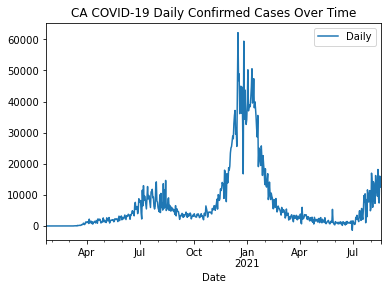

In [5]:
dr = confirmed_df[['Daily']]
dr.plot()
plt.title('CA COVID-19 Daily Confirmed Cases Over Time');

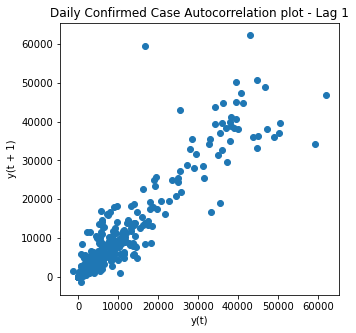

In [6]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(confirmed_df['Daily'], lag=1)
plt.title('Daily Confirmed Case Autocorrelation plot - Lag 1');


# Build Train-Test Datasets- Daily Cases

In [7]:
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.6), :], confirmed_df.iloc[int(len(confirmed_df)*0.6):, :]

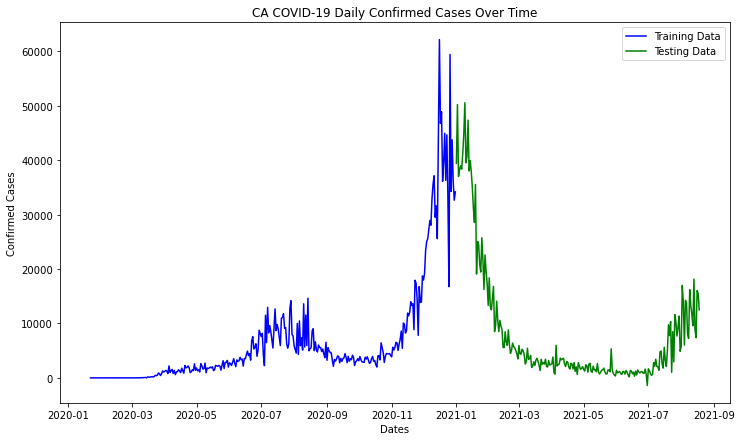

In [8]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_data['Daily'], 'blue', label='Training Data')
plt.plot(test_data['Daily'], 'green', label='Testing Data')
plt.legend();

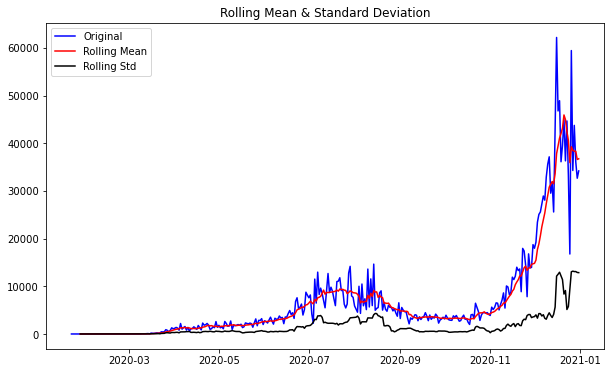

In [9]:
window = 7
train_series = train_data['Daily']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [10]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -2.431648
p-value                          0.133002
#Lags Used                      17.000000
Number of Observations Used    327.000000
Critical Value (1%)             -3.450507
Critical Value (5%)             -2.870420
Critical Value (10%)            -2.571501
dtype: float64

# Apply a first order differencing on the training data

In [11]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)

In [12]:
train_diff

Date
2020-01-23        0.0
2020-01-24        0.0
2020-01-25        0.0
2020-01-26        2.0
2020-01-27       -2.0
               ...   
2020-12-27   -25143.0
2020-12-28     9455.0
2020-12-29    -7645.0
2020-12-30    -3435.0
2020-12-31     1530.0
Name: Daily, Length: 344, dtype: float64

# Visualize Rolling statistics for differenced train data

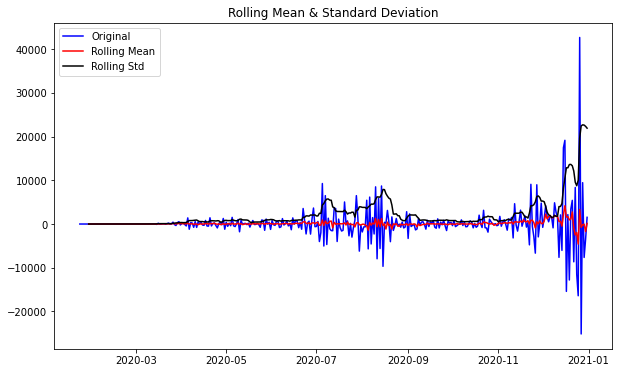

In [13]:
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

# Compute AD-Fuller Stats for differenced train data

In [14]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -4.712280
p-value                          0.000080
#Lags Used                      10.000000
Number of Observations Used    333.000000
Critical Value (1%)             -3.450141
Critical Value (5%)             -2.870259
Critical Value (10%)            -2.571415
dtype: float64

# Plot ACF and PACF on the original train series

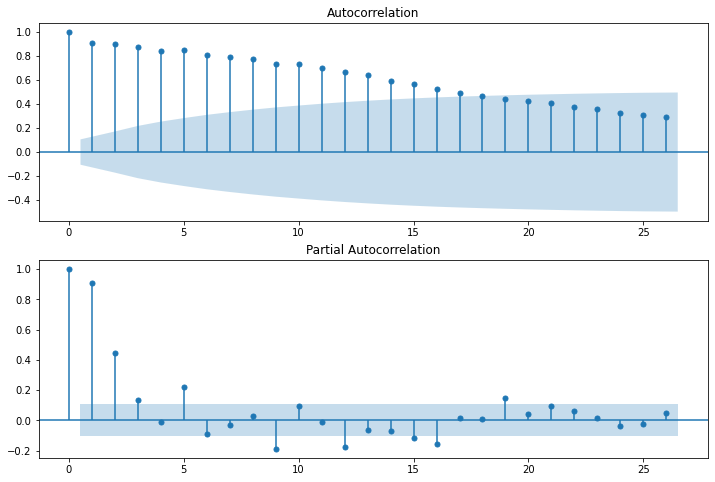

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

# Plot ACF and PACF on the differenced train series

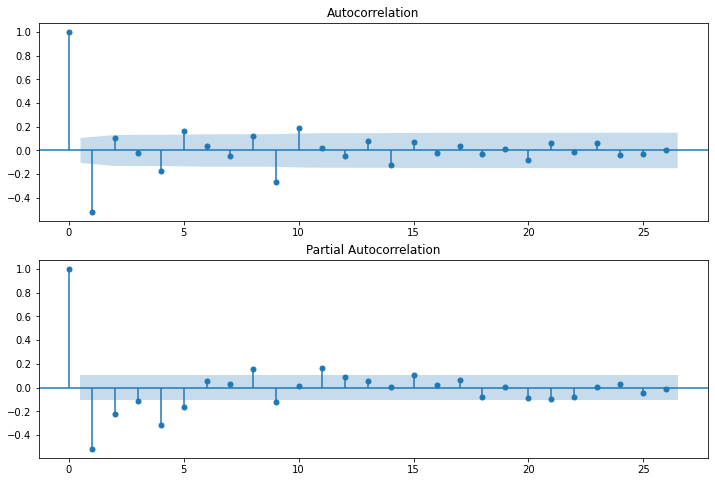

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# Evaluation of ARIMA Model

In [17]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# Difference the Test Series

In [18]:
test_series = test_data['Daily']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
test_diff

Date
2021-01-02    10797.0
2021-01-03   -13206.0
2021-01-04     1240.0
2021-01-05      706.0
2021-01-06     -599.0
               ...   
2021-08-14    -9329.0
2021-08-15    -1457.0
2021-08-16     8658.0
2021-08-17     -554.0
2021-08-18    -2973.0
Name: Daily, Length: 229, dtype: float64

# Train and Forecast using ARIMA Model by filling in the necessary blocks

In [19]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [20]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    model = ARIMA(history, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model

    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

Wall time: 1min 14s


In [21]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    model = ARIMA(history, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0)  # fit the model
   
    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=10699.559901994377, Expected=10797.0
Test Series Point: 100	Predicted=-1151.163412414453, Expected=108.0
Test Series Point: 200	Predicted=-1431.8997112184352, Expected=-1999.0
Wall time: 1min 14s


# Reverse Transform the forecasted values

In [22]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((230,), (230,))

# Evaluate model performance

In [23]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 30706169.059
Symmetric Mean absolute percentage error: 143.545


In [24]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

# Visualize the forecast results

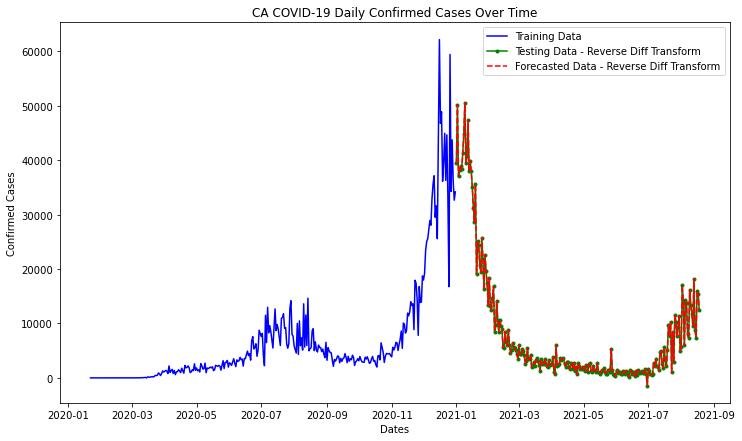

In [25]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Data - Reverse Diff Transform')
plt.legend();

# Visualize only test and forecast prices

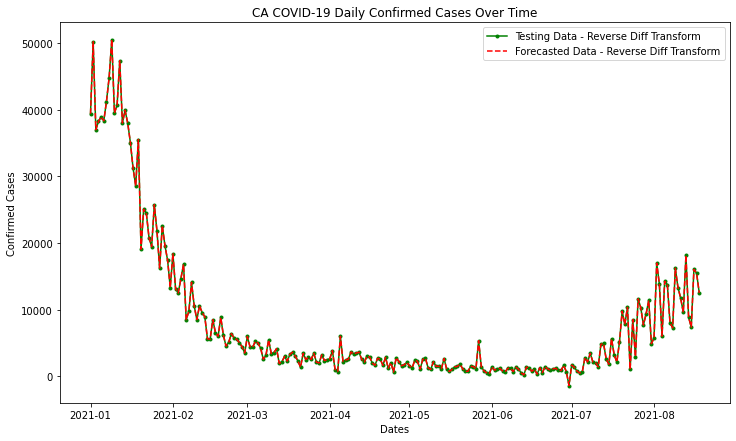

In [26]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Data - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Data - Reverse Diff Transform')
plt.legend();

# 5. Daily Confirmed Cases Prediction- LSTM

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

#%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [9]:
confirmed_df = pd.read_csv("time_series_covid19_confirmed_CA_Transposed.csv")
confirmed_df.isnull().values.any()
confirmed_df = confirmed_df.dropna()

confirmed_df.index = pd.to_datetime(confirmed_df['Date'])
confirmed_df.tail()

,Date,84006001,84006003,84006005,84006007,84006009,84006011,84006013,84006015,84006017,...,84006103,84006105,84006107,84006109,84090006,84006111,84006113,84006115,SUM,Daily
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-14,8/14/2021,101473,91,4169,14179,2564,2459,81823,2060,12001,...,6214,526,51770,5053,107,86440,15761,7562,4124955,8834
2021-08-15,8/15/2021,101876,91,4206,14192,2579,2459,82150,2060,12019,...,6214,526,51951,5053,84,86569,15815,7562,4132332,7377
2021-08-16,8/16/2021,102101,91,4231,14263,2599,2565,82440,2240,12195,...,6214,532,52046,5148,132,86977,15877,7584,4148367,16035
2021-08-17,8/17/2021,102751,91,4235,14448,2609,2565,82850,2275,12298,...,6214,542,52162,5192,181,87202,15933,7737,4163848,15481
2021-08-18,8/18/2021,103075,91,4266,14518,2624,2565,82850,2306,12363,...,6214,545,52362,5235,73,87601,15986,7789,4176356,12508


# Build Train-Test Datasets- Daily Cases

In [31]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.6), :], confirmed_df.iloc[int(len(confirmed_df)*0.6):, :]
train_series = train_data['Daily']
test_series = test_data['Daily']
train_series.shape, test_series.shape

((345,), (230,))

# Visualize train and test data

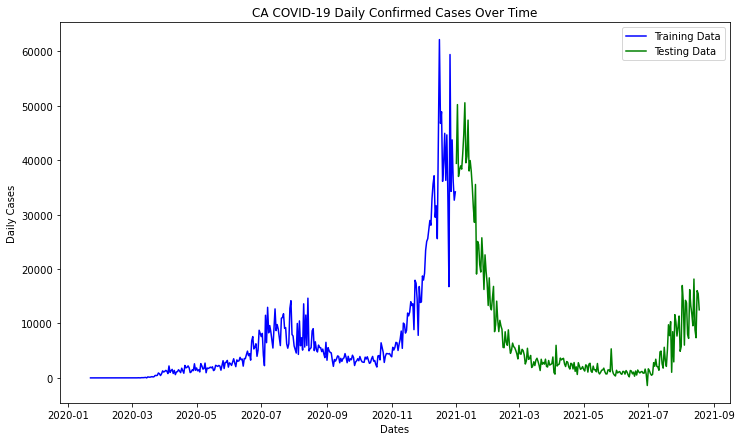

In [32]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Daily Cases')
plt.plot(train_data['Daily'], 'blue', label='Training Data')
plt.plot(test_data['Daily'], 'green', label='Testing Data')
plt.legend();

# Scaling

In [33]:
sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(train_series.values.reshape(-1,1))
training_set_scaled

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [3.21708918e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [4.82563377e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [3.21708918e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],
       [1.60854459e-05],
       [0.00000000e+00],


In [34]:
training_set_scaled.shape

(345, 1)

# Train Data Preparation

In [35]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((285, 60), (285,))

In [36]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [37]:
X_train.shape

(285, 60, 1)

# Build the LSTM based forecasting DL Model architecture

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries

In [39]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(loss='mse', optimizer='rmsprop')

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [40]:
regressor.fit(X_train,y_train, epochs=10, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/10
4/4 [==============================] - 8s 621ms/step - loss: 0.0036 - val_loss: 0.1466
Epoch 2/10
4/4 [==============================] - 0s 68ms/step - loss: 0.0022 - val_loss: 0.0958
Epoch 3/10
4/4 [==============================] - 0s 78ms/step - loss: 0.0024 - val_loss: 0.0685
Epoch 4/10
4/4 [==============================] - 0s 79ms/step - loss: 0.0021 - val_loss: 0.0469
Epoch 5/10
4/4 [==============================] - 0s 86ms/step - loss: 0.0019 - val_loss: 0.0393
Epoch 6/10
4/4 [==============================] - 0s 84ms/step - loss: 0.0015 - val_loss: 0.0343
Epoch 7/10
4/4 [==============================] - 0s 87ms/step - loss: 0.0013 - val_loss: 0.0337
Epoch 8/10
4/4 [==============================] - 0s 98ms/step - loss: 0.0012 - val_loss: 0.0366
Epoch 9/10
4/4 [==============================] - 0s 83ms/step - loss: 0.0012 - val_loss: 0.0360
Epoch 10/10
4/4 [==============================] - 0s 87ms/step - loss: 0.0010 - val_loss: 0.0362


# Test Data Forecasting

# Get the last 60 records from train_series

In [41]:
train_last60 = train_series[-60:]
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [42]:
test_series.shape

(230,)

In [43]:
print(test_series)

Date
2021-01-01    39425
2021-01-02    50222
2021-01-03    37016
2021-01-04    38256
2021-01-05    38962
              ...  
2021-08-14     8834
2021-08-15     7377
2021-08-16    16035
2021-08-17    15481
2021-08-18    12508
Name: Daily, Length: 230, dtype: int64


# Combine both train_last60 and test_series together

In [44]:
new_test_series =  pd.concat([train_last60, test_series], axis=0)
print(new_test_series.shape)
#assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(290,)


# Scale the test dataset using the trained MinMaxScaler transformer - sc

In [45]:
test_set_scaled = sc.transform(new_test_series.values.reshape(-1, 1))

# Prepare Test dataset Windows of 60 days each

In [46]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(230, 60, 1)

# Model Prediction and Reverse Transform

In [47]:
predicted_confirmed_cases = regressor.predict(X_test)
predicted_confirmed_cases_revtrans = sc.inverse_transform(predicted_confirmed_cases).ravel()
predicted_confirmed_cases_revtrans_series = pd.Series(predicted_confirmed_cases_revtrans)
predicted_confirmed_cases_revtrans_series.index = test_series.index
predicted_confirmed_cases_revtrans_series.shape, test_series.shape

((230,), (230,))

# Model Evaluation

In [48]:
error = mean_squared_error(test_series, predicted_confirmed_cases_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_confirmed_cases_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 30514089.018
Symmetric Mean absolute percentage error: 53.270


# Visualizing the results from model predictions

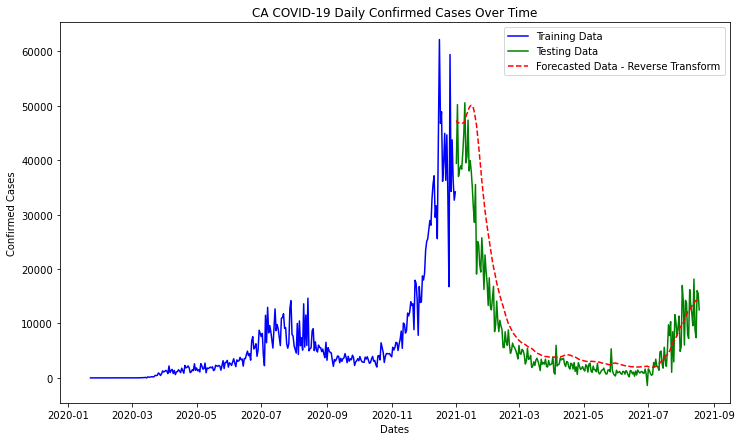

In [49]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Forecasted Data - Reverse Transform')
plt.legend();

# Visualize only test and forecast data

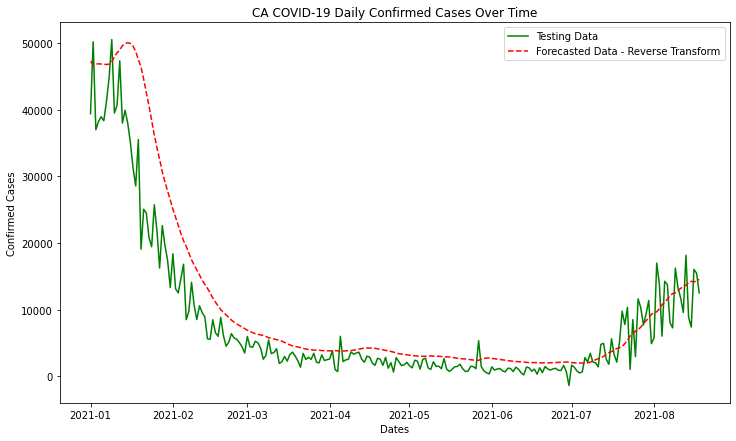

In [50]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Daily Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Forecasted Data - Reverse Transform')
plt.legend();

# 6. Total Confirmed Cases Prediction- LSTM

# Build Train-Test Datasets- Total Cases

In [10]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = confirmed_df.iloc[0:int(len(confirmed_df)*0.6), :], confirmed_df.iloc[int(len(confirmed_df)*0.6):, :]
train_series = train_data['SUM']
test_series = test_data['SUM']
train_series.shape, test_series.shape

((345,), (230,))

# Visualize train and test data

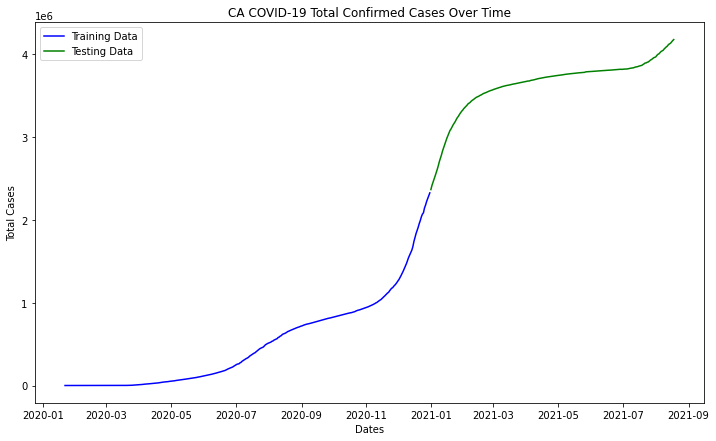

In [11]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Total Cases')
plt.plot(train_data['SUM'], 'blue', label='Training Data')
plt.plot(test_data['SUM'], 'green', label='Testing Data')
plt.legend();

# Scaling

In [12]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train_series.values.reshape(-1,1))
training_set_scaled

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [8.59993490e-07],
       [8.59993490e-07],
       [8.59993490e-07],
       [8.59993490e-07],
       [8.59993490e-07],
       [1.28999023e-06],
       [1.28999023e-06],
       [1.28999023e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [2.57998047e-06],
       [3.00997721e-06],
       [3.00997721e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [3.43997396e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.29996745e-06],
       [4.72996419e-06],
       [4.72996419e-06],
       [5.15996094e-06],
       [5.15996094e-06],


In [13]:
training_set_scaled.shape

(345, 1)

# Train Data Preparation

In [14]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((285, 60), (285,))

In [15]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [16]:
X_train.shape

(285, 60, 1)

# Build the LSTM based forecasting DL Model architecture

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries

In [18]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(loss='mse', optimizer='rmsprop')

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [19]:
regressor.fit(X_train,y_train, epochs=5, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/5
4/4 [==============================] - 34s 796ms/step - loss: 0.0072 - val_loss: 0.0189
Epoch 2/5
4/4 [==============================] - 0s 91ms/step - loss: 0.0011 - val_loss: 0.0203
Epoch 3/5
4/4 [==============================] - 0s 83ms/step - loss: 6.6835e-04 - val_loss: 0.0012
Epoch 4/5
4/4 [==============================] - 0s 91ms/step - loss: 0.0022 - val_loss: 0.0135
Epoch 5/5
4/4 [==============================] - 0s 92ms/step - loss: 0.0026 - val_loss: 0.0036


# Test Data Forecasting¶

# Get the last 60 records from train_series¶

In [20]:
train_last60 = train_series[-60:]
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [21]:
test_series.shape

(230,)

In [22]:
print(test_series)

Date
2021-01-01    2365024
2021-01-02    2415246
2021-01-03    2452262
2021-01-04    2490518
2021-01-05    2529480
               ...   
2021-08-14    4124955
2021-08-15    4132332
2021-08-16    4148367
2021-08-17    4163848
2021-08-18    4176356
Name: SUM, Length: 230, dtype: int64


# Combine both train_last60 and test_series together

In [23]:
new_test_series =  pd.concat([train_last60, test_series], axis=0)
print(new_test_series.shape)
#assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(290,)


# Scale the test dataset using the trained MinMaxScaler transformer - sc

In [24]:
test_set_scaled = sc.transform(new_test_series.values.reshape(-1, 1))

# Prepare Test dataset Windows of 60 days each

In [25]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(230, 60, 1)

# Model Prediction and Reverse Transform

In [26]:
predicted_confirmed_cases = regressor.predict(X_test)
predicted_confirmed_cases_revtrans = sc.inverse_transform(predicted_confirmed_cases).ravel()
predicted_confirmed_cases_revtrans_series = pd.Series(predicted_confirmed_cases_revtrans)
predicted_confirmed_cases_revtrans_series.index = test_series.index
predicted_confirmed_cases_revtrans_series.shape, test_series.shape

((230,), (230,))

# Model Evaluation

In [27]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

In [28]:
error = mean_squared_error(test_series, predicted_confirmed_cases_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_confirmed_cases_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 100532056531.386
Symmetric Mean absolute percentage error: 8.133


# Visualizing the results from model predictions

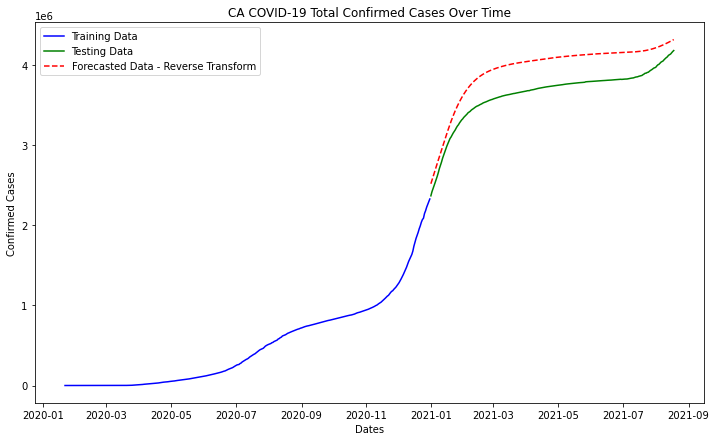

In [29]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(train_series, color='blue', label='Training Data')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Forecasted Data - Reverse Transform')
plt.legend();

# Visualize only test and forecast data

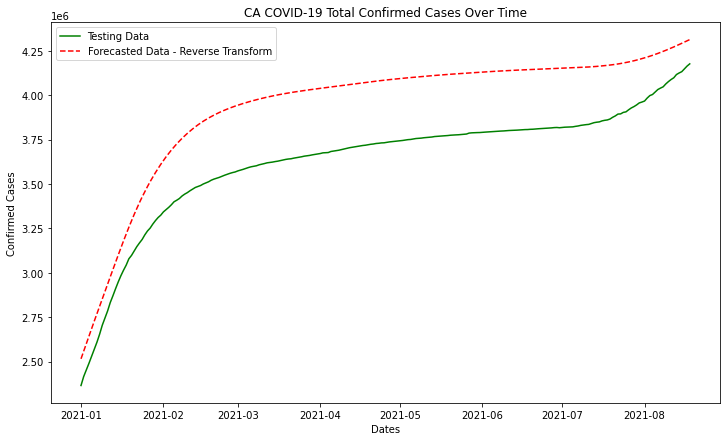

In [30]:
plt.figure(figsize=(12,7))
plt.title('CA COVID-19 Total Confirmed Cases Over Time')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.plot(test_series, color='green', label='Testing Data')
plt.plot(predicted_confirmed_cases_revtrans_series, color='red', linestyle='--', label='Forecasted Data - Reverse Transform')
plt.legend();